In [18]:
import numpy as np
import scipy.stats

import jax.numpy as jnp
from jax import jit, vmap, grad
import jax.random

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore")

In [19]:
title = "# Simulation-based inference"
# Print title and setup TeX defs for both KaTeX and MathJax
import bayesian_stats_course_tools
bayesian_stats_course_tools.misc.display_markdown_and_setup_tex(title)

import matplotlib.style
matplotlib.style.use("bayesian_stats_course_tools.light")

# Simulation-based inference

<!-- Define LaTeX macros -->
$\def\E{\operatorname{E}}$
$\def\Var{\operatorname{Var}}$
$\def\Cov{\operatorname{Cov}}$
$\def\dd{\mathrm{d}}$
$\def\ee{\mathrm{e}}$
$\def\Norm{\mathcal{N}}$
$\def\Uniform{\mathcal{U}}$

<!-- MathJax needs them to be defined again for the non-inline environment -->
$$\def\E{\operatorname{E}}$$
$$\def\Var{\operatorname{Var}}$$
$$\def\Cov{\operatorname{Cov}}$$
$$\def\dd{\mathrm{d}}$$
$$\def\ee{\mathrm{e}}$$
$$\def\Norm{\mathcal{N}}$$
$$\def\Uniform{\mathcal{U}}$$

## Simulation-based inference

If our data generating process is complex, we might not be able to write down a likelihood density function that computes the probability of the data given the parameters.

We can usually still sample data realisations from this likelihood by building a forward model or simulator that reproduces the data-generating process.

- For a given $x$ and $\theta$, we cannot compute the density $p(x|\theta)$
- But we can sample $x_i|\theta\sim p(\cdot|\theta)$

In simulation-based inference we make posterior inference using only the data-generating process, without evaluating likelihood functions.


## Approximate Bayesian computation (ABC)

The simplest implementation is rejection ABC.

1. Sample $\theta_i$ from the prior
2. Generate $y^\mathrm{rep}_i$ from the forward model, based on $\theta_i$
3. Accept $\theta_i$ if some distance metric $d(y, y^\mathrm{rep}_i)$ between $y$ and $y^\mathrm{rep}_i$ is smaller than a threshold $\epsilon$

For an in-depth review of ABC, see for example [Sisson et al. 2018](https://doi.org/10.1201/9781315117195).

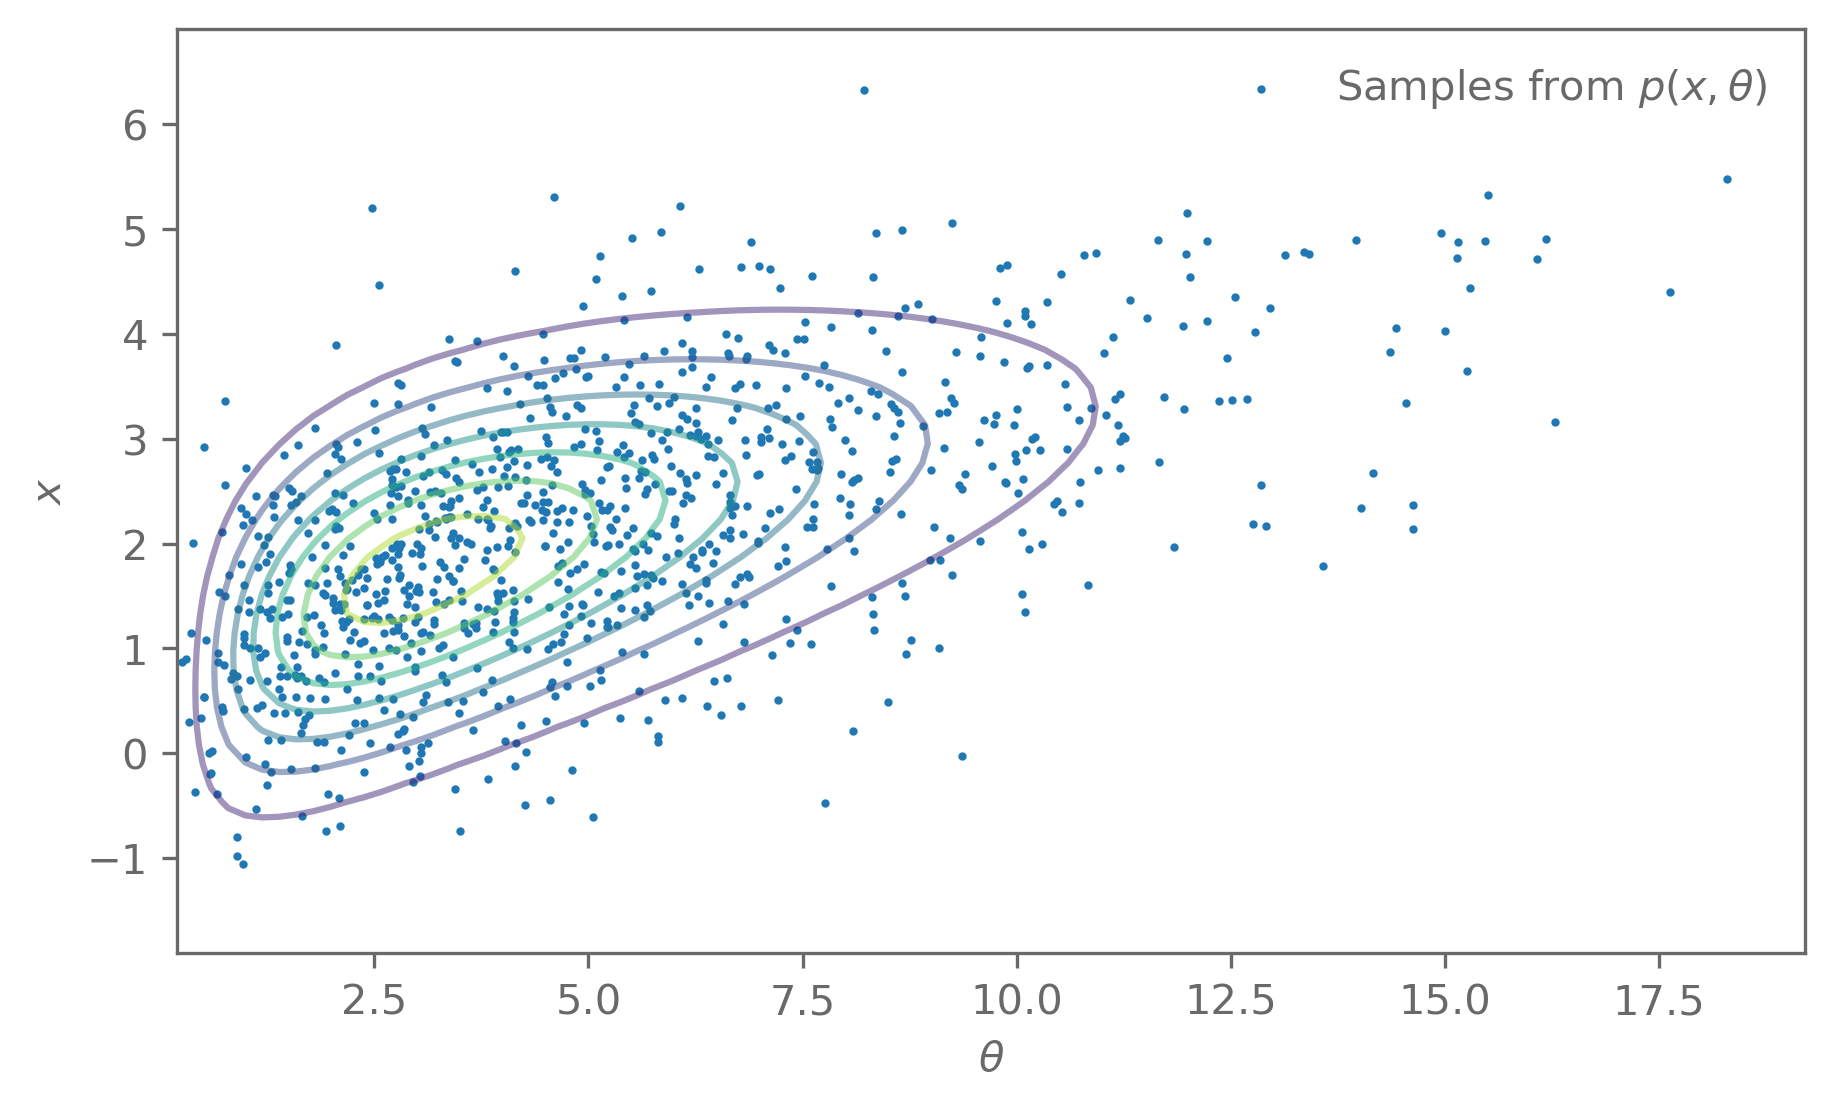

In [21]:
prior_distr = scipy.stats.chi2(df=5)

def likelihood_distr(theta):
    return scipy.stats.norm(loc=np.sqrt(theta), scale=1)

def joint_pdf(theta, x):
    joint_pdf = prior_distr.pdf(theta) * likelihood_distr(theta).pdf(x)
    return joint_pdf

n = 1000
theta_samples = prior_distr.rvs(n)
x_samples = likelihood_distr(theta_samples).rvs(n)

theta_grid = np.linspace(0.1, 15, 75)
x_grid = np.linspace(-2, 7, 50)
coords = np.dstack(np.meshgrid(theta_grid, x_grid)).reshape(-1, 2)

joint_grid = np.array([joint_pdf(*c) for c in coords]).reshape(x_grid.size, theta_grid.size)
fig, ax = plt.subplots()

ax.scatter(theta_samples, x_samples, s=1, label=r"Samples from $p(x, \theta)$")
ax.contour(joint_grid, origin="lower", alpha=0.5,
              extent=(theta_grid[0], theta_grid[-1], x_grid[0], x_grid[-1]))
ax.set_xlabel(r"$\theta$")
ax.set_ylabel(r"$x$")
_ = ax.legend()


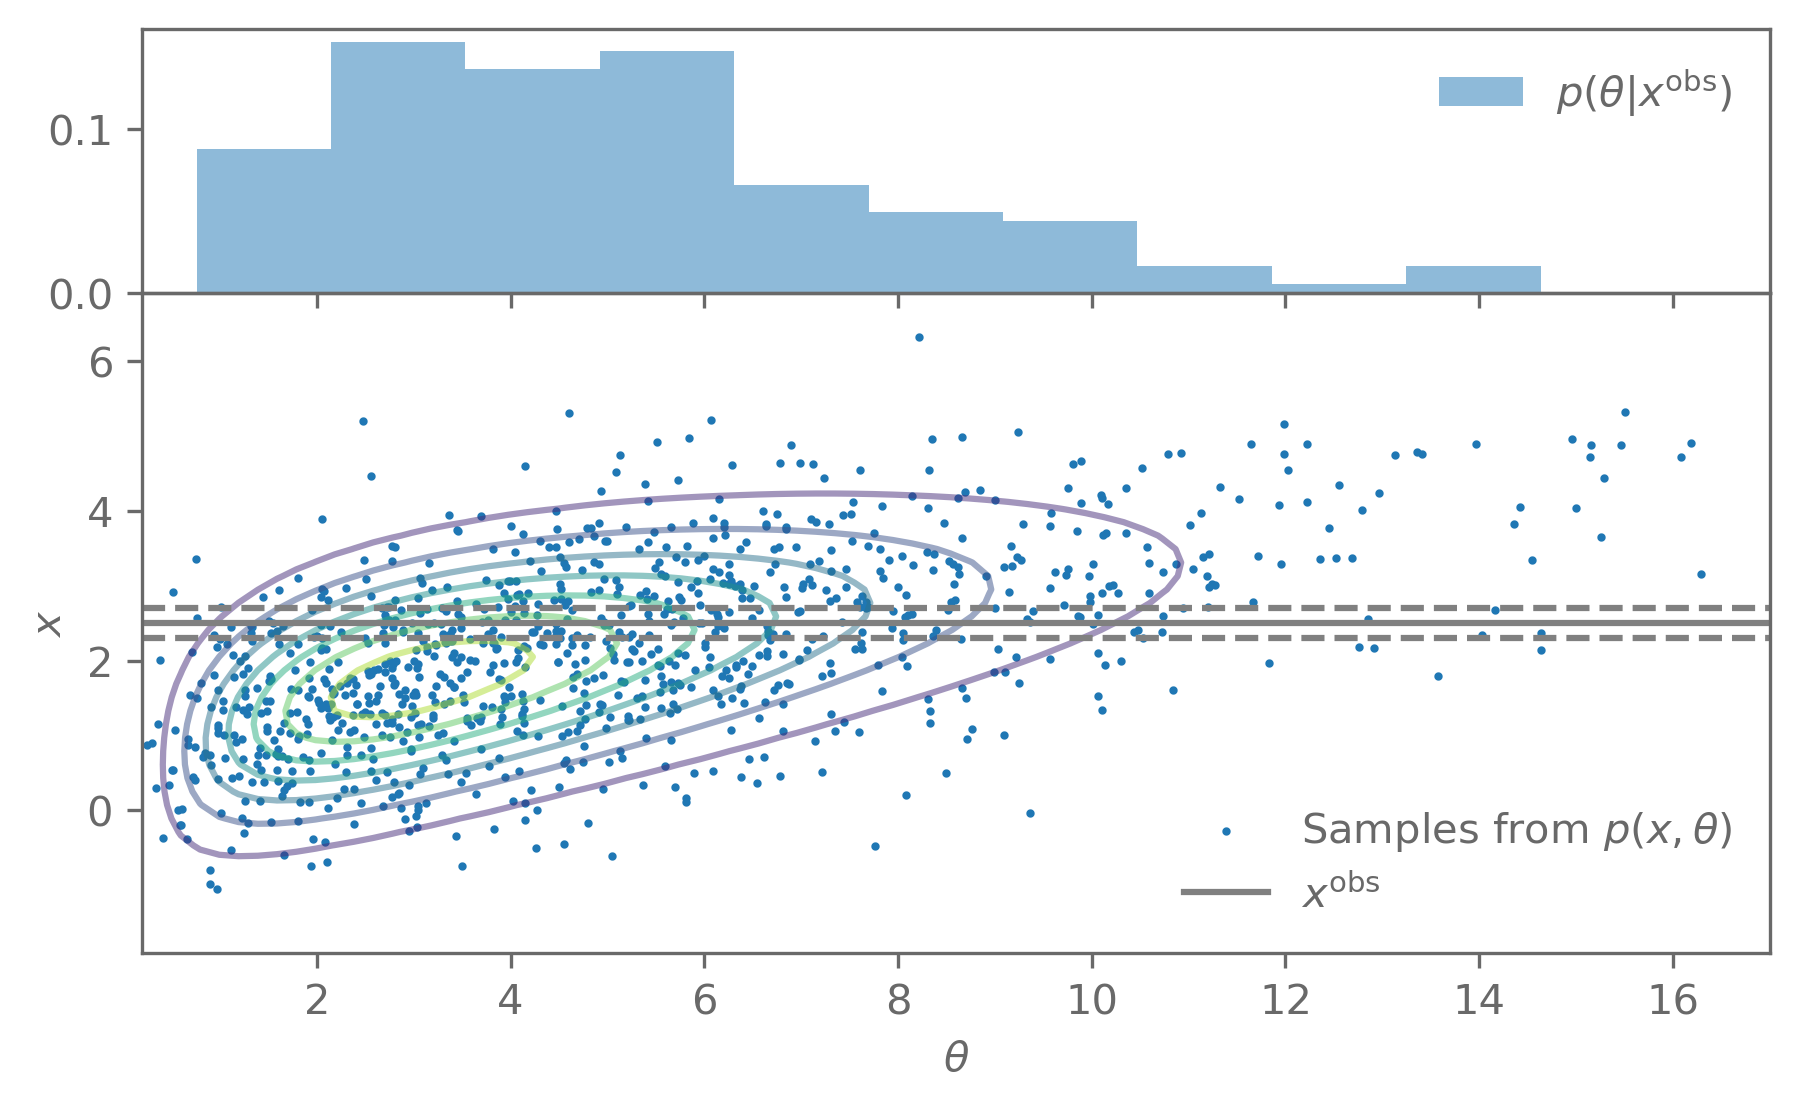

In [23]:
fig, ax = plt.subplots(
    2, 1, sharex="col",
    # figsize=(7, 5),
    gridspec_kw=dict(
        height_ratios=[0.4, 1.0],
        wspace=0, hspace=0
    )
)

ax[1].scatter(theta_samples, x_samples, s=1, label=r"Samples from $p(x, \theta)$")
ax[1].contour(joint_grid, origin="lower", alpha=0.5,
              extent=(theta_grid[0], theta_grid[-1], x_grid[0], x_grid[-1]))

x_true = 2.5
epsilon = 0.2

ax[1].axhline(x_true, color="grey", label=r"$x^\mathrm{obs}$")
ax[1].axhline(x_true-epsilon, color="grey", ls="--")
ax[1].axhline(x_true+epsilon, color="grey", ls="--")
ax[1].set_xlim(right=17)
ax[0].hist(theta_samples[np.abs(x_samples-x_true) < epsilon],
           density=True, alpha=0.5, label=r"$p(\theta|x^\mathrm{obs})$")

ax[1].set_xlabel(r"$\theta$")
ax[1].set_ylabel(r"$x$")
ax[1].legend()
ax[0].legend();

- If $\epsilon$ is chosen too small, the acceptance rate will be low
- If $\epsilon$ is chosen too large, the approximation to the posterior will be poor
- If the dimensionality of the data is large, we are hit with the curse of dimensionality and the acceptance rate will be very low.
    - To combat this, usually summary statistics are used. If these summary statistics are not sufficient statistics (capturing all the information of the data), then some information will be lost

Number of accepted samples for 𝜖 = 0.1: 509/10000
Number of accepted samples for 𝜖 = 1.5: 6484/10000


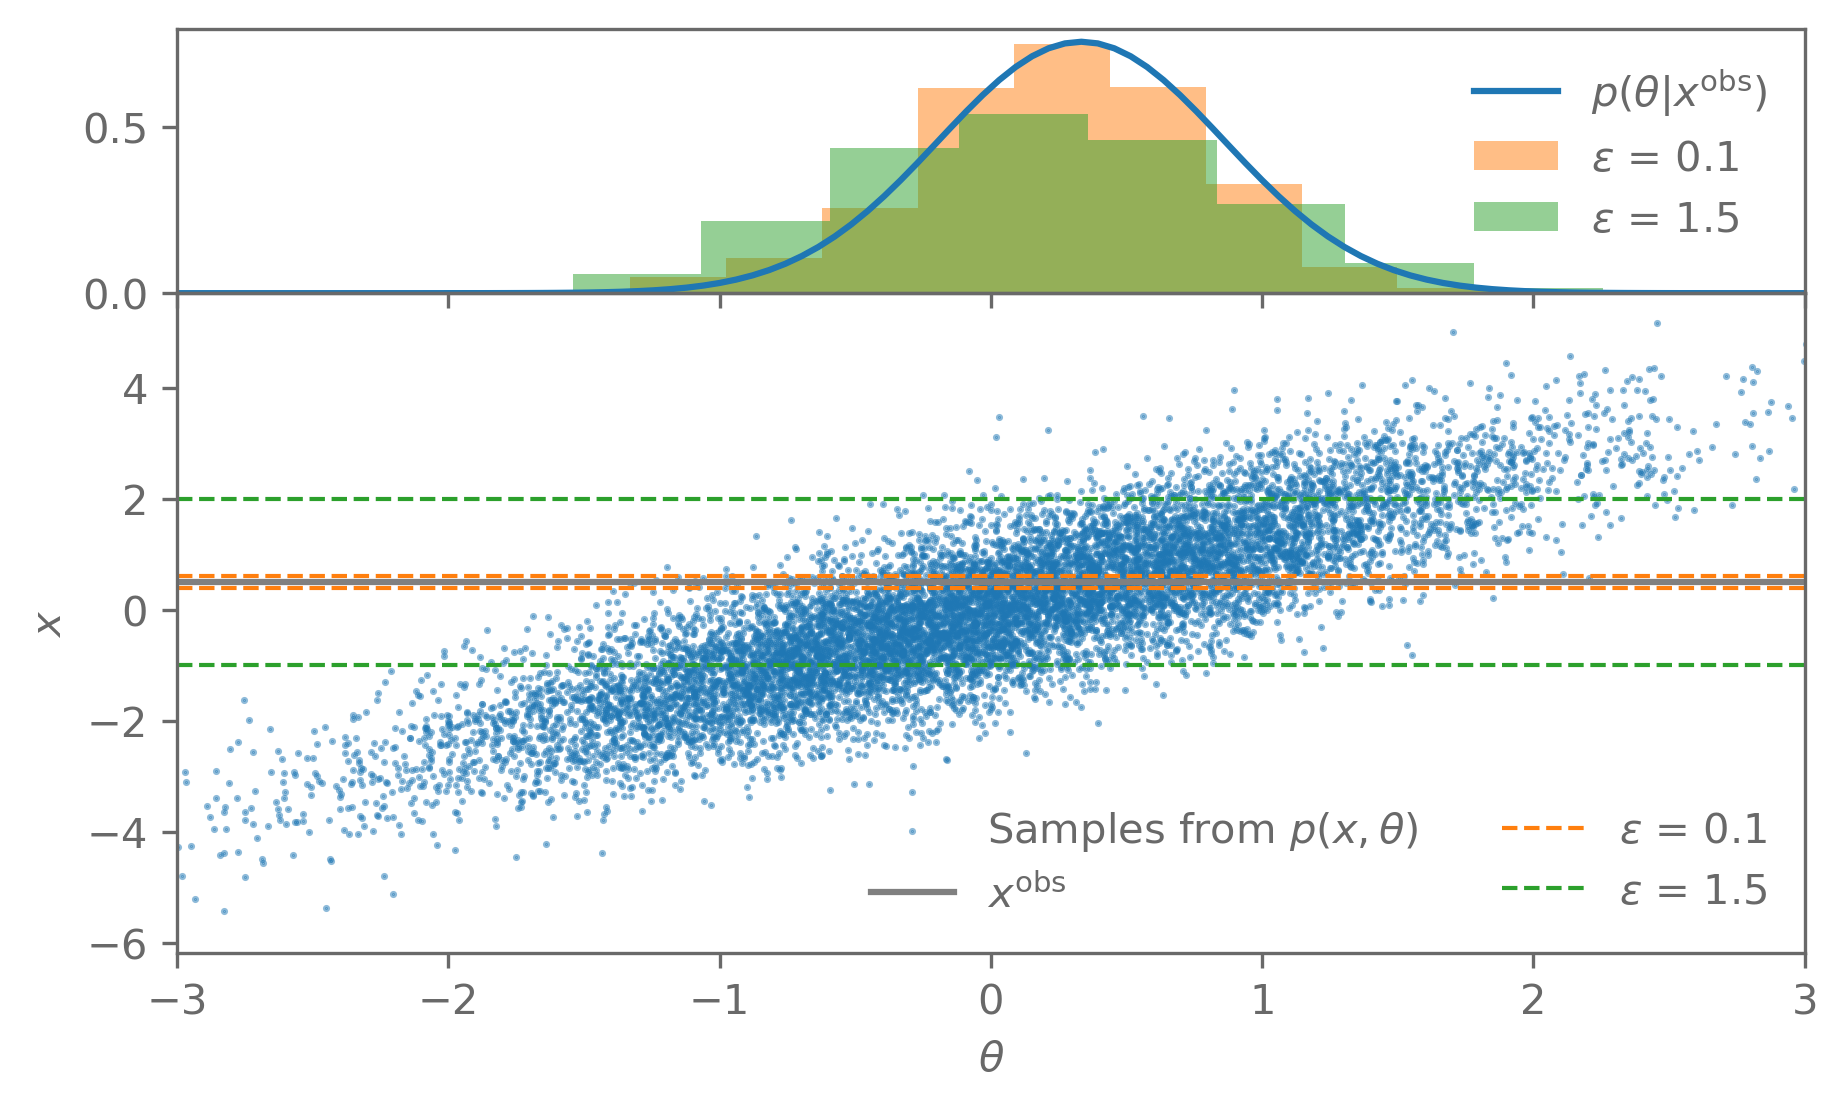

In [93]:
# Define variances and correlation
sigma_x = 1.5
sigma_theta = 1
rho = 0.85

mu_x = 0
mu_theta = 0
# Define mean and covariance
mean = np.array([mu_x, mu_theta])
cov = np.array([[sigma_x**2, sigma_x*sigma_theta*rho],
                 [sigma_x*sigma_theta*rho, sigma_theta**2]])
joint_distr = scipy.stats.multivariate_normal(mean=mean, cov=cov)

x_obs = 0.5

distr_theta_cond_x_obs = scipy.stats.norm(
    loc=mu_theta + sigma_theta/sigma_x*(x_obs-mu_x),
    scale=np.sqrt((1-rho**2)*sigma_theta**2)
)

samples = joint_distr.rvs(10000)
samples = samples[:, ::-1]

fig, ax = plt.subplots(
    2, 1, sharex="col",
    # figsize=(7, 5),
    gridspec_kw=dict(
        height_ratios=[0.4, 1.0], hspace=0
    )
)

theta_grid = np.linspace(-3, 3, 100)
ax[0].set_xlim(-3, 3)

ax[0].plot(theta_grid, distr_theta_cond_x_obs.pdf(theta_grid), label=r"$p(\theta|x^\mathrm{obs})$")

ax[1].scatter(*samples.T, s=0.5, alpha=0.5, label=r"Samples from $p(x, \theta)$")

ax[1].axhline(x_obs, color="grey", label=r"$x^\mathrm{obs}$")

for i, epsilon in enumerate([0.1, 1.5]):
    selection = np.abs(samples[:,1]-x_obs) < epsilon
    print(f"Number of accepted samples for 𝜖 = {epsilon}: {selection.sum()}/{len(selection)}")
    ax[0].hist(
        samples[selection, 0],
        density=True, alpha=0.5, color=f"C{i+1}", #histtype="step",
        label=r"$\epsilon$ = " + f"{epsilon}")

    ax[1].axhline(x_obs-epsilon, color=f"C{i+1}", ls="--", lw=1,
                  label=r"$\epsilon$ = " + f"{epsilon}")
    ax[1].axhline(x_obs+epsilon, color=f"C{i+1}", ls="--", lw=1)

ax[1].set_xlabel(r"$\theta$")
ax[1].set_ylabel(r"$x$")
ax[1].legend(ncols=2)
ax[0].legend();

## Neural density estimation

Often the simulators are expensive to run and producing samples from the likelihood or posterior is expensive.

The idea of (conditional) density estimation is to estimate a probability density function that approximates the true distribution that the samples came from.

We want to fit an approximate distribution $q_\phi(x)$, which is parametrised by $\phi$.


The optimisation objective is often the Kullback-Leibler (KL) divergence
$$
    D_\mathrm{KL}(p \| q) = \int p(x)\log\frac{p(x)}{q(x)}\dd x
$$
between the true distribution $p$ and our approximation $q$.

The KL divergence measures how well the two distributions agree:
- $D_\mathrm{KL}(p \| q) = 0$ when the distributions agree
- $D_\mathrm{KL}(p \| q) \geq 0$ in general
- Not symmetric
- Mutual information $I(X, Y) = D_\mathrm{KL}(p(X, Y) \| p(X)p(Y))$

We want to fit an approximate distribution $q_\phi(x)$, which is parametrised by $\phi$.

$$
    D_\mathrm{KL}(p \| q_\phi) = \E_p\left[\log\frac{p(x)}{q_\phi(x)}\right] \\
    = \E_p\left[-\log q_\phi(x)\right] + \underbrace{\E_p\left[\log p(x)\right]}_{\text{does not depend on } q_\phi}
$$
The second term $\E_p\left[\log p(x)\right]$ does not depend on $\phi$, so it can be ignored when optimising:
$$
    \phi^* = \underset{\phi}{\mathrm{argmin}}\ D_\mathrm{KL}(p \| q_\phi)  =\underset{\phi}{\mathrm{argmin}}\  \E_p\left[-\log q_\phi(x)\right]
$$



Given samples $x_i \sim p$ from the target distribution, the loss function for the optimisation is then
$$
    L(\phi) = \E_p\left[-\log q_\phi(x)\right] \approx -\frac{1}{n}\sum_i \log q_\phi(x_i)
$$

In [100]:
# We will use tensorflow probability wit JAX
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

# Define a Gaussian mixture model
# We use logits (log of probabilities) and log of standard deviations as 
# parameters to make optimisation easier
def gmm(logits, means, log_stds):
    distr = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(logits=logits),
        components_distribution=tfd.Normal(loc=means, scale=jnp.exp(log_stds))
    )
    return distr

# Put in some test parameters
mixture = gmm(
    logits=jnp.log(jnp.array([0.5, 0.7])),
    means=jnp.array([0.0, 2.0]),
    log_stds=jnp.log(jnp.array([0.3, 0.7])),
)

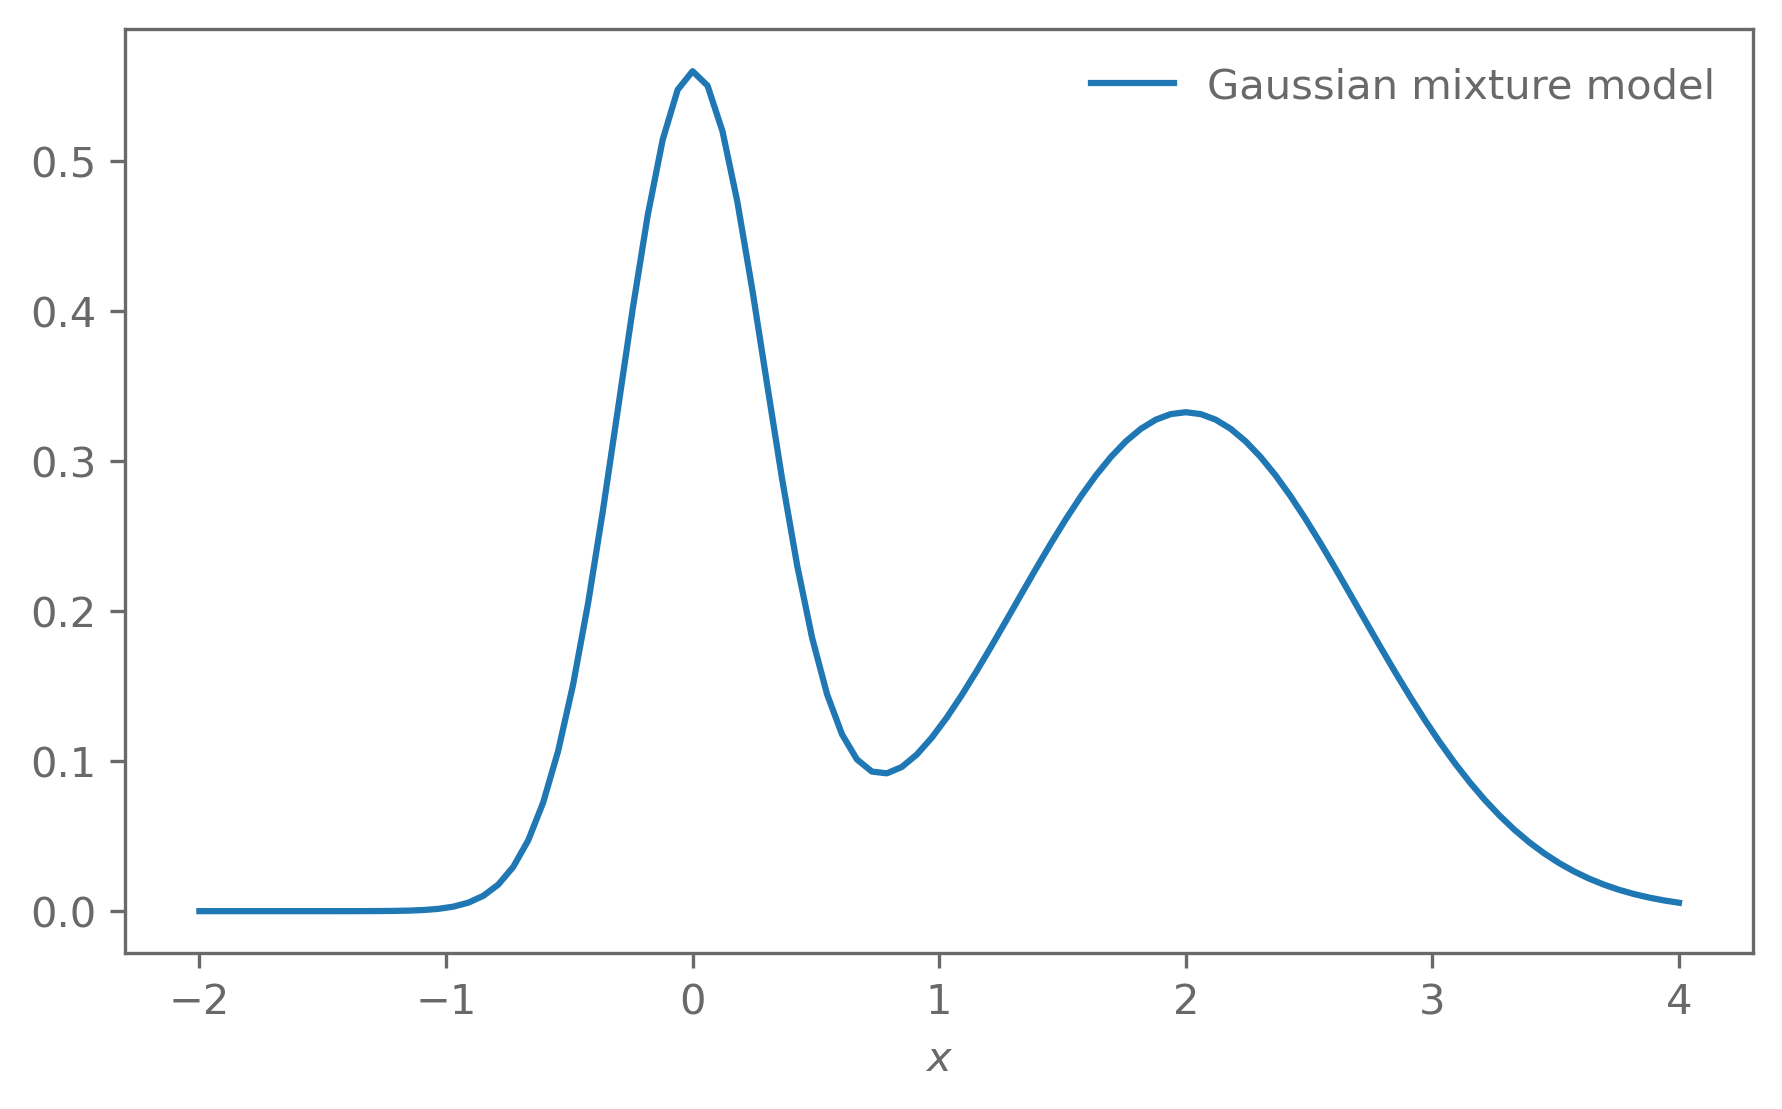

In [101]:
x = np.linspace(-2, 4, 100)
plt.plot(x, mixture.prob(x), label="Gaussian mixture model")
plt.xlabel("$x$")
plt.legend();

Let us now fit a distribution.

In [105]:
target_distr = scipy.stats.gamma(a=3, scale=1/3)
target_distr_samples = target_distr.rvs(1000)

In [106]:
import jaxopt

# Define the loss function
def loss_fn(params):
    variational_distr = gmm(**params)
    loss = jnp.mean(-variational_distr.log_prob(target_distr_samples))
    return loss

key, *subkeys = jax.random.split(jax.random.PRNGKey(42), 4)

# We will use a 5-component Gaussian mixture model
n_components = 5
theta_init = dict(
    logits=jax.random.normal(key=subkeys[0], shape=(n_components,)),
    means=jax.random.normal(key=subkeys[1], shape=(n_components,)),
    log_stds=jax.random.normal(key=subkeys[2], shape=(n_components,)),
)

# Fit the model
solver = jaxopt.ScipyMinimize(fun=jit(loss_fn))
solution = solver.run(theta_init)

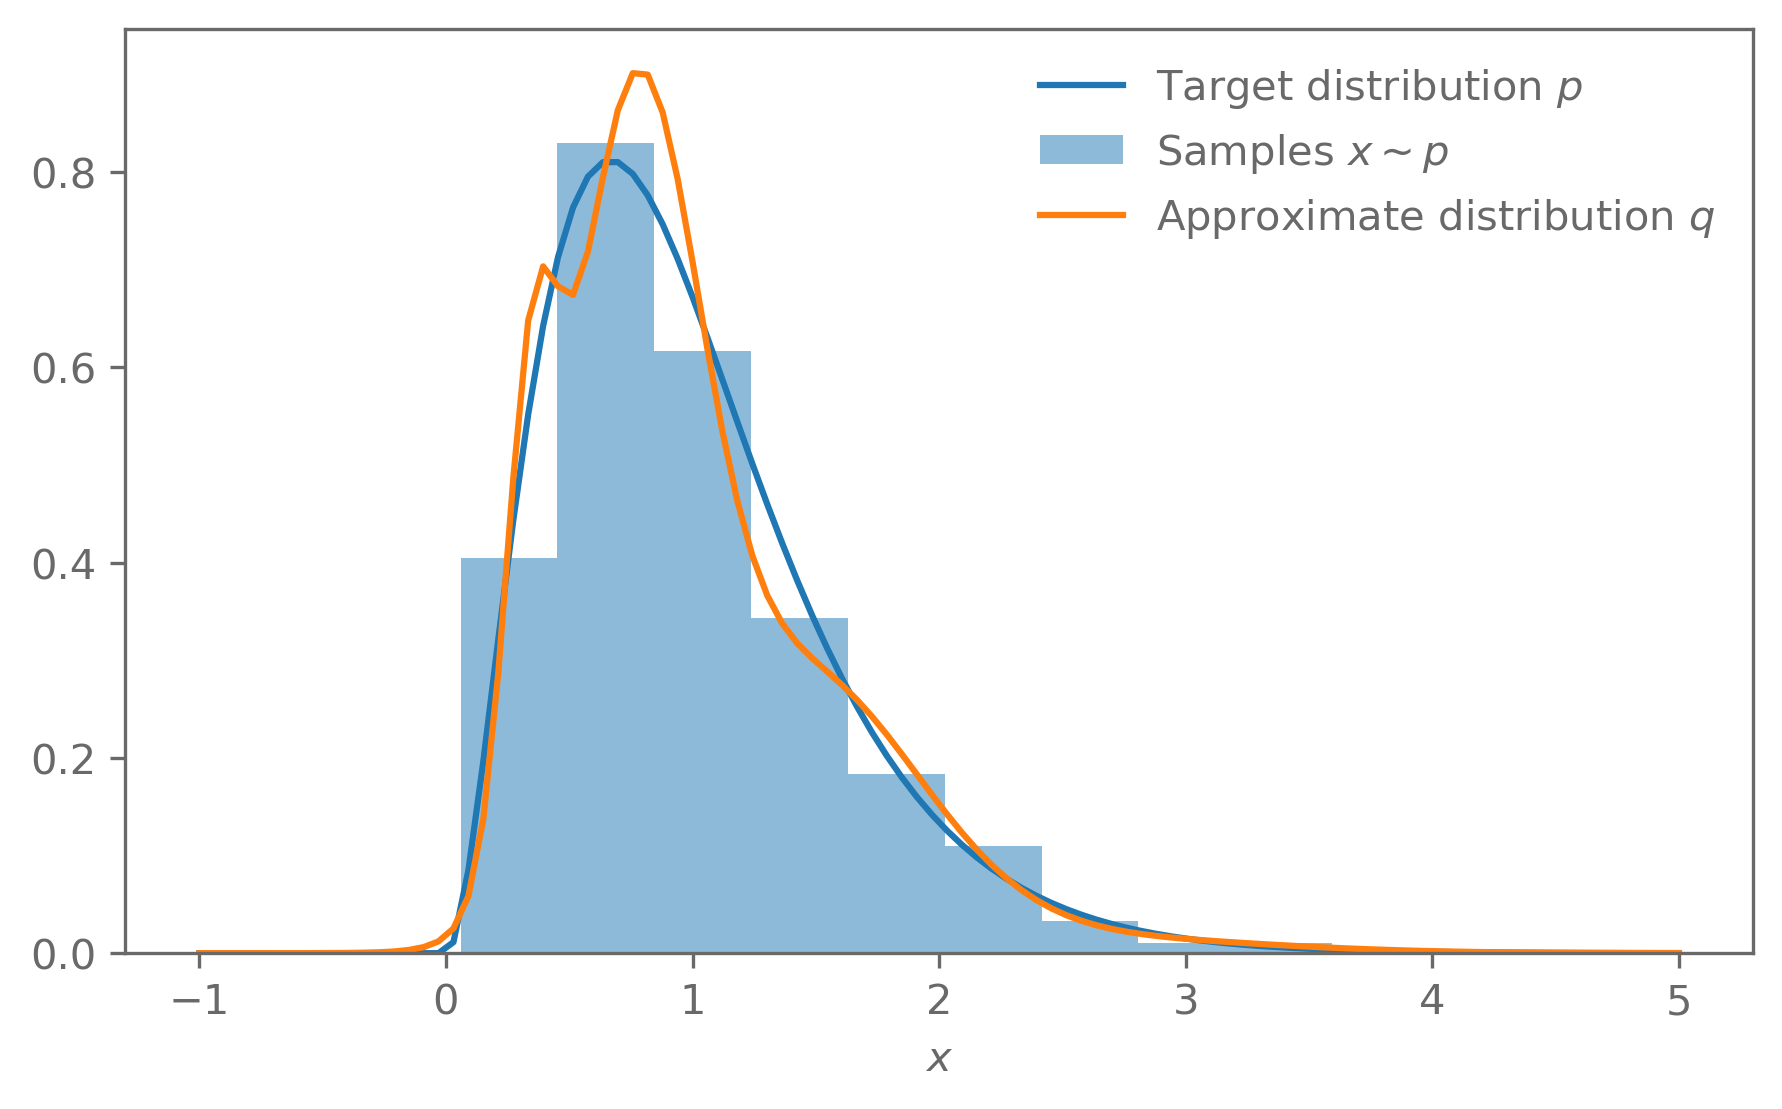

In [111]:
x = np.linspace(-1, 5, 100)
plt.plot(x, target_distr.pdf(x), label="Target distribution $p$")
plt.hist(target_distr_samples, density=True, alpha=0.5, color="C0", label="Samples $x\sim p$")
plt.plot(x, gmm(**solution.params).prob(x), color="C1", label="Approximate distribution $q$")
plt.legend()
plt.xlabel("$x$");

Once we have fit $q_\phi$ we can use it to create new samples very quickly.

We can also do conditional density estimation by defining a function that first maps $x$ to the parameters $\phi$ of our approximate distribution.

If we use a neural network for that mapping from $x$ to $\phi$ and/or to define flexible distributions, we talk about (conditional) neural density estimation.


When used to approximate the likelihood $p(x|\theta)$, this is called neural likelihood estimation.
- Once we have the approximate likelihood $q_\phi(x|\theta)$, we can continue to our usual Bayesian workflow with sampling the posterior, since now we have a likelihood where we can compute the density.

When used to approximate the posterior $p(\theta|x)$ directly, this is call neural posterior estimation.
- This has the advantage that once we have found $q_\phi(\theta|x)$, we can reuse this for many different observations $x^\mathrm{obs}$ without having to run an MCMC.
- If we change the priors, we need to redo the process, however.



Neural density estimation is often amortised: after creating the training set of pairs of $(\theta_i, x_i)$ and fitting the approximate distribution $q_\phi$, we can do inference very quickly for different observed data and parameters.

In contrast, ABC is not amortised: the posterior we estimate is specific to a single observation and everything needs to be redone for different observations.

### Further resources

A python package that implements a number of simulation-based inference algorithms (using pytorch) is [sbi](https://www.mackelab.org/sbi/).

A brief overview of recent developments [Cranmer et al. 2020](10.1073/pnas.1912789117) and some discussion on when things can go wrong [Hermans et al. 2022](https://arxiv.org/abs/2110.06581).

## Exercises

Try rejection ABC on the linear-fit example. Think about what distance metric you want to use, since the data vector is now multidimensional.


## Loss functions and posteriors

### A (very) quick intro to machine learning and neural networks

Machine learning is fundamentally about finding pattern in data. 

There are different flavours of machine learning, today we focus on supervised learning.

In supervised learning, we have 
- a training set $D = \{x_i, y_i\}$ of pairs of inputs $x_i$ and outputs $y_i$,
- a function $f_\theta(x)$ with parameters $\theta$, such that $y = f_\theta(x) + \epsilon$, where $\epsilon$ is some noise.



We want to predict the outputs $y^*$ for inputs $x^*$ not in the training set:  $p(y^* | x^*, x, y)$.

The input-output pairs can be anything: from 1D points $x$ and $y$ that we model with linear regression to assigning labels to images:
- $x_i$ = <img style="display:inline; vertical-align:middle; height: 4em" src="../assets/cat_small.jpg">, 
    $y_i$ = "cat"
- $x_j$ = <img style="display:inline; vertical-align:middle; height: 4em" src="../assets/dog_small.jpeg">, 
    $y_j$ = "dog"
- etc


The distribution over outputs from unseen inputs $p(y^* | x^*, x, y)$ is just the posterior predictive distribution that we have seen and used before:
$$
    p(y^* | x^*, x, y) = \int p(y^* | x^*,\theta)p(\theta | x, y)\dd \theta\,.
$$



The direct Bayesian approach we learned is: 
- define likelihood $p(y | x,\theta)$ and prior $p(\theta|x)$
- sample posterior $\theta_i \sim p(\cdot | x, y)$
- sample prediction from likelihood $y_i^* \sim p(\cdot| x^*, \theta_i)$.



In machine learning, especially deep learning, $f_\theta(x)$ can be very complex:
- <span style="font-size: x-large"> f<sub>θ</sub>(<img style="display:inline; vertical-align:middle; height: 3em" src="../assets/cat_small.jpg">)</span> = "cat"
- <span style="font-size: x-large"> f<sub>θ</sub>(<img style="display:inline; vertical-align:middle; height: 3em" src="../assets/dog_small.jpeg">)</span> = "dog"

The function $f_\theta(x)$ can have millions or billions of parameters $\theta$. Not even Hamilton Monte Carlo will help you there.




In machine learning, the problem is therefore usually phrased as an optimisation problem where we want to minimise some loss function $L(x, y, \theta)$ such that the differences between the training outputs $y_i$ and $f_\theta(x_i)$ is minimised.

Common loss functions for regression are
- $L_2$ loss: $L(x, y, \theta) = \|f_\theta(x) - y\|^2$
- $L_1$ loss: $L(x, y, \theta) = \|f_\theta(x) - y\|$


To find $f_\theta(x)$, we minimise the expectation of the loss function over the (training) data distribution $p(x, y)$:
$$
    \theta^* = \underset{\theta}{\mathrm{argmin}} \E_{p(x,y)}\left[L(x,y,\theta)\right]\,.
$$

Or for a finite training set ${x_i, y_i}$, $i=1,\dots,n$:
$$
    \theta^* = \underset{\theta}{\mathrm{argmin}} \frac{1}{n}\sum_i^n L(x_i,y_i,\theta)\,.
$$



How does the choice of the loss function affect what kind of function $f_\theta(x)$ we get?

Let us look at this (very simple) dataset of points $(x_i, y_i)$ drawn from some (unknown) distribution $p(x, y)$.

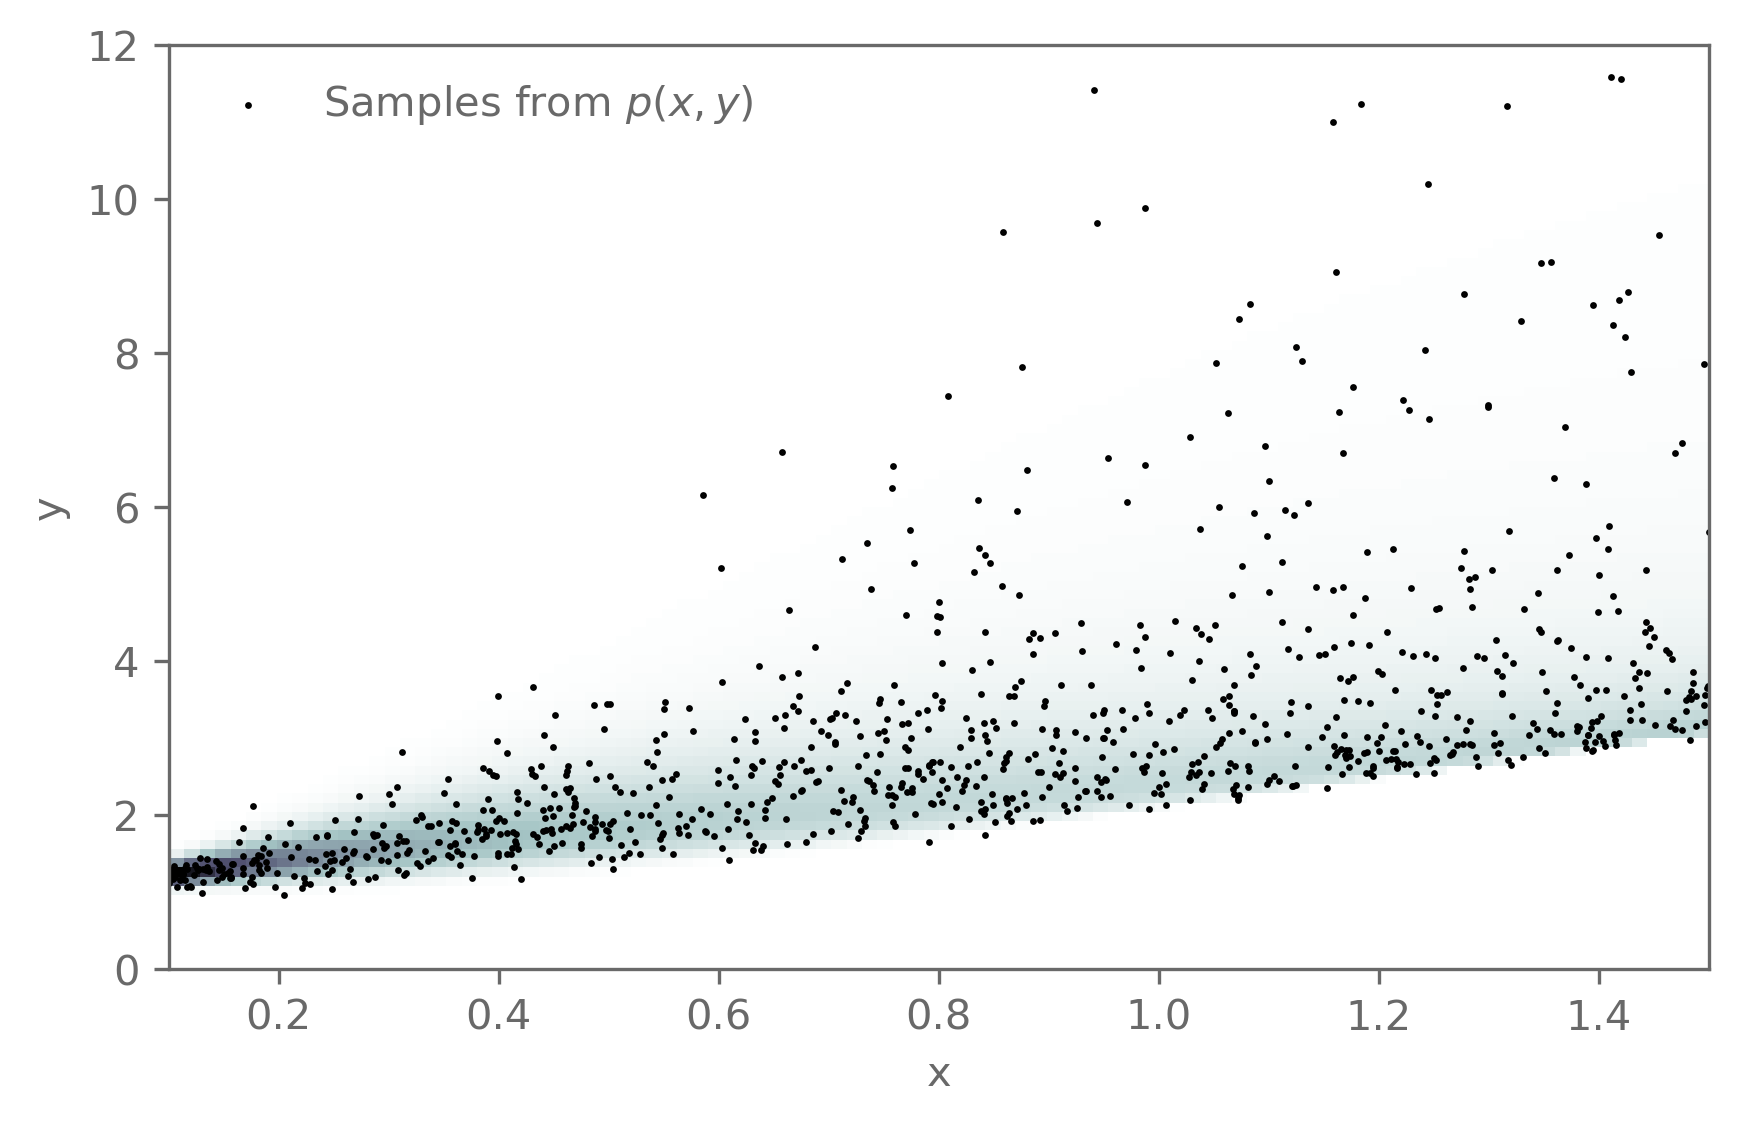

In [24]:
def distr(x):
    d =  scipy.stats.lognorm(s=x, loc=2*x)
    # Patch in mode method for log-normal distribution
    def mode(x=x):
        return np.exp(-x**2) + 2*x
    d.mode = mode
    return d  

x = np.random.uniform(0.1, 1.5, size=1000)
y = distr(x).rvs()

fig, ax = plt.subplots(1, 1)
ax.scatter(x, y, s=0.4, color="black", label="Samples from $p(x, y)$")

x_grid = np.linspace(0.1, 1.5, 100)

ax.legend(frameon=False)

y_grid = np.linspace(0, 12, 100)
pdf_grid = distr(x_grid).pdf(y_grid[:,None])
ax.imshow(
    pdf_grid,
    origin="lower",
    extent=(min(x_grid), max(x_grid), min(y_grid), max(y_grid)),
    cmap="bone_r"
)
ax.set_aspect(0.07)

ax.set_xlabel("x")
ax.set_ylabel("y");

We want to find a function $f_\theta(x)$ that best describes the relationship between $x$ and $y$.

If we have no physical model, we can use a general, flexible function. The more complex the data is, the more flexible the function needs to be.

One way to define very flexible functions is using artifical neural networks.


The output $\vec y$ is computed from the input $\vec x$ as
\begin{align*}
    \vec h^{(1)} &= \sigma( W^{(1)}\vec x + \vec b^{(1)}) \\
    \vec h^{(2)} &= \sigma( W^{(2)}\vec h^{(1)} + \vec b^{(2)}) \\
    \dots \\
    \vec h^{(L)} &= \sigma( W^{(L)}\vec h^{(L-1)} + \vec b^{(L)}) \\
    \vec y &= W^{(L+1)}\vec h^{(L)} + \vec b^{(L+1)}\,.
\end{align*}

The hidden layers $\vec h^{(i)}$ are computed by first linearly transforming the input using the weight matrices $W^{(i)}$ and biases $\vec b^{(i)}$ and then applying a _non-linear_ activation function $\sigma(\cdot)$.

This is repeated for $L$ layers, where the hidden layer $\vec h^{(i)}$ is used as input compute the next layer $\vec h^{(i+1)}$.

At the end, there is a final function to map $\vec h^{(L)}$ to the output $\vec y$.

This is a very powerful way to define flexible functions. 

The universal approximation theorems state that if the activation function $\sigma(\cdot)$ is non-polynomial and the network is sufficiently large, then such a neural network can approximate _any_ function.

For our example, we use a fully-connected (or dense) neural network.

Fully-connected means that the weights $W^{(i)}$ are matrices $W^{(i)} \in \mathbb{R}^{n\times m}$ that connect all inputs to a layer to all its outputs. 

Other neural network architecures, for example convolutional neural networks, connect subsets of the layer inputs to the outputs.


For an introduction to deep learning in JAX, have a look at the very extensive lectures from the University of Amsterdam:
https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial2/Introduction_to_JAX.html#

For our example, we implement a neural network using JAX and the `flax` library.

In [9]:
import flax.linen as nn

# Define a two-layer multilayer perceptron (MLP)
class MLP(nn.Module):
    n_hidden: int = 128  # Size of hidden layer dimension
    n_output: int = 1    # Size of output dimension

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=self.n_hidden)(x)
        x = nn.swish(x)  # We use the swish activation function
        x = nn.Dense(features=self.n_hidden)(x)
        x = nn.swish(x)
        x = nn.Dense(features=self.n_output)(x)
        return x

We train the network using the $L_2$ loss:
$$
    L_2(x, y, \theta) = \|y - f_\theta(x)\|^2\,.
$$
This corresponds to least-squares if with homoscedastic errors.

In [17]:
def L2_loss_fn(params, model, x, y):
    predictions = model.apply(params, x)

    mse = (predictions - y)**2
    return jnp.mean(mse)

To optimise the parameters $\theta$ (which consist of the weights and biases $W^{(l)}$ and biases $\vec b^{(l)}$), we use (stochastic) gradient descent.

In gradient descent, we compute the loss on our training set $D = \{x_i, y_i\}$:
$$
    L(D, \theta) = \frac{1}{n}\sum_i L(x_i, y_i, \theta) \,.
$$

We then update the parameters using the gradient of the loss:
$$
    \theta \rightarrow \theta -\gamma\nabla_\theta L(D,\theta)\,,
$$
where $\gamma$ is the _learning rate_. This process is repeated until convergence.



Because the size of training data can be very large in practice, instead of minimising the expected loss over all $n$ training points $\{x_i, y_i\}$, we compute the gradient only on batches $B_i$ of the training data. A batch $B_i \subset D$ is a subset of the training data.
$$
    \theta \rightarrow \theta -\gamma\nabla_\theta L(B_i,\theta)\,.
$$
This is repeated for all batches. This is called stochastic gradient descent, because it replaces the loss over the whole data set $L(D, \theta)$ with a noisy approximation $L(B_i,\theta)$.

In [11]:
import optax
import tqdm

# Get n samples from our target distribution
def get_batch(n=64):
    x = np.random.uniform(0.1, 1.5, size=(n, 1))
    y = distr(x).rvs()
    return x, y


def train(model, loss_fn, n_iter, seed):
    # Initialise the model
    x, y = get_batch()
    params = model.init(seed, x)

    # Set up the optimiser. Here we use Adam, which is a variant of 
    # stochastic gradient descent
    optimizer = optax.adam(learning_rate=0.001)
    opt_state = optimizer.init(params)

    # This function takes care of applying the parameters with the gradients
    @jax.jit
    def update_model(params, opt_state, x, y):
        # Computes the gradients of the model
        loss, grads = jax.value_and_grad(loss_fn)(params, model, x, y)

        # Computes the weights updates and apply them
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)

        return params, opt_state, loss

    # Now run the actual optimisation
    progress = tqdm.tqdm(range(n_iter))
    for i in progress:
        # Get a batch of data
        x, y = get_batch(n=1024)

        # Apply the update function
        params, opt_state, loss = update_model(params, opt_state, x, y)

        # Print the current loss
        progress.set_postfix({"loss": loss})
    
    return params, loss

Define our model for the function $f_\theta(x)$ (the neural network) and train it using the $L_2$ loss:

In [25]:
model = MLP()

params, loss = train(model, L2_loss_fn, n_iter=1000, seed=jax.random.PRNGKey(42))
L2_trained_model = model.bind(params)

100%|██████████| 1000/1000 [00:05<00:00, 192.63it/s, loss=5.672119] 


Let us to the same thing for the $L_1$ loss:

In [27]:
def L1_loss_fn(params, model, x, y):
    predictions = model.apply(params, x)

    return jnp.mean(jnp.abs(predictions - y))

params, loss = train(model, L1_loss_fn, n_iter=1000, seed=jax.random.PRNGKey(42))
L1_trained_model = model.bind(params)

100%|██████████| 1000/1000 [00:04<00:00, 201.16it/s, loss=1.3839406]


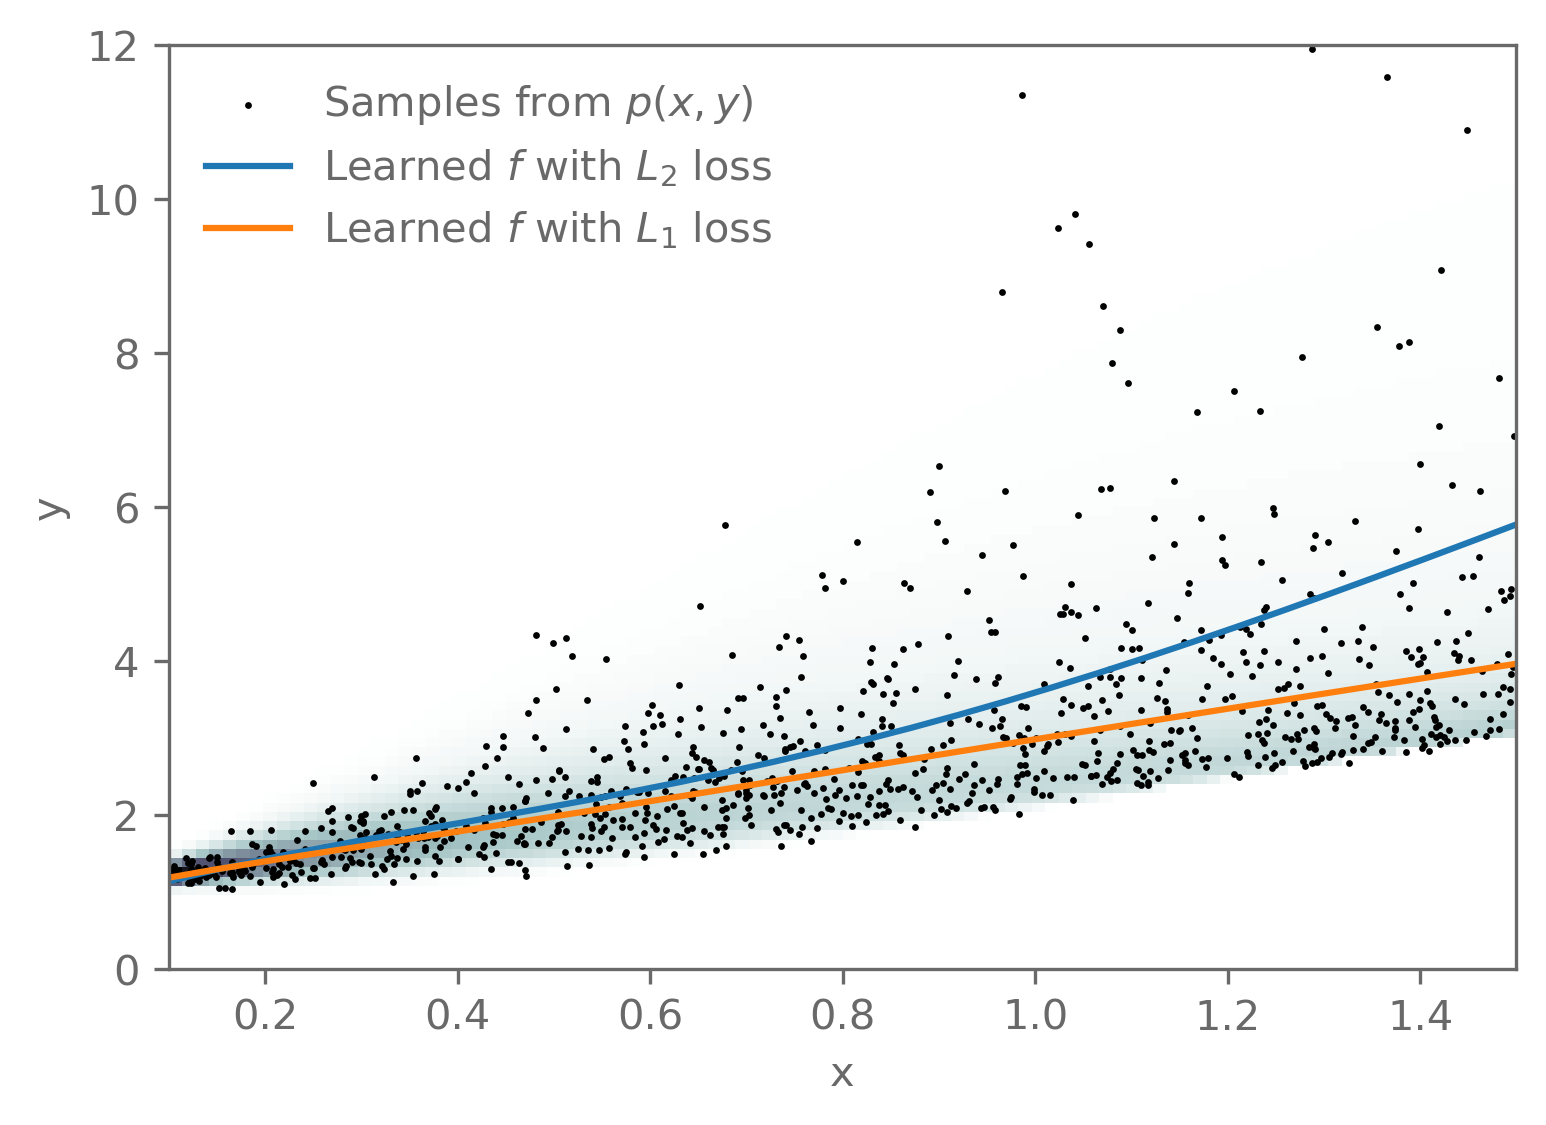

In [14]:
x_test = jnp.linspace(0.1, 1.5, 30)

L1_predictions_test = L1_trained_model(x_test[:, None])
L2_predictions_test = L2_trained_model(x_test[:, None])

fig, ax = plt.subplots(1, 1)
ax.scatter(x, y, s=0.4, color="black", label="Samples from $p(x, y)$")

ax.plot(x_test, L2_predictions_test, ls="-", c="C0", label="Learned $f$ with $L_2$ loss")
ax.plot(x_test, L1_predictions_test, ls="-", c="C1", label="Learned $f$ with $L_1$ loss")

ax.legend(frameon=False)

x_grid = np.linspace(0.1, 1.5, 100)
y_grid = np.linspace(0, 12, 100)
pdf_grid = distr(x_grid).pdf(y_grid[:,None])
ax.imshow(
    pdf_grid,
    origin="lower",
    extent=(min(x_grid), max(x_grid), min(y_grid), max(y_grid)),
    cmap="bone_r"
)
ax.set_aspect(0.08)

ax.set_xlabel("x")
ax.set_ylabel("y");

Why are the functions learned with different losses different? Or a better question, what functions did we learn?


The expected loss over the population distribution $p(x,y)$ is given by
$$
    L_2 = \E_{p(x, y)}[\|y-f(x)\|^2] = \int \|y-f\|^2 p(x, y)\dd x\dd y\,.
$$



We want to find a function $f$ that minimises the functional
$$
    I[f] = \int \|y-f(x)\|^2 p(x, y)\dd x\dd y = \int \left(\int\|y-f(x)\|^2 p(y|x)p(x)\dd y\right)\dd x = \int \mathcal{L}(x, y, f) \dd x \,,
$$
where we defined
$$
    \mathcal{L}(x, y, f) = p(x)\int\|y-f(x)\|^2 p(y|x)\dd y \,.
$$

The Euler-Lagrange equation tells us that the function $f$ that minimises $I$ satisfies
$$
    \frac{\partial\mathcal{L}}{\partial f} = 0 \,,
$$
since $\mathcal{L}$ does not depend on derivatives of $f$.



Using
$$
    \int \|y-f\|^2 p(y|x)\dd y = \int^f (f-y)^2 p(y|x)\dd y + \int_f (y-f)^2 p(y|x)\dd y\,,
$$
we find
$$
    \frac{\partial\mathcal{L}}{\partial f} = -2p(x)\int \left(y-f(x)\right) p(y|x)\dd y = 0
$$
and we get
\begin{align*}
    f(x) &= \int y p(y|x)\dd y = \E_{p(y|x)}[y] \\
\end{align*}
The function $f$ that minimises the $L_2$ loss is therefore the mean of the conditional distribution $p(y|x)$.

What if we had used another loss function?  For example $L_1(y, f(x)) = |y - f(x)|$?

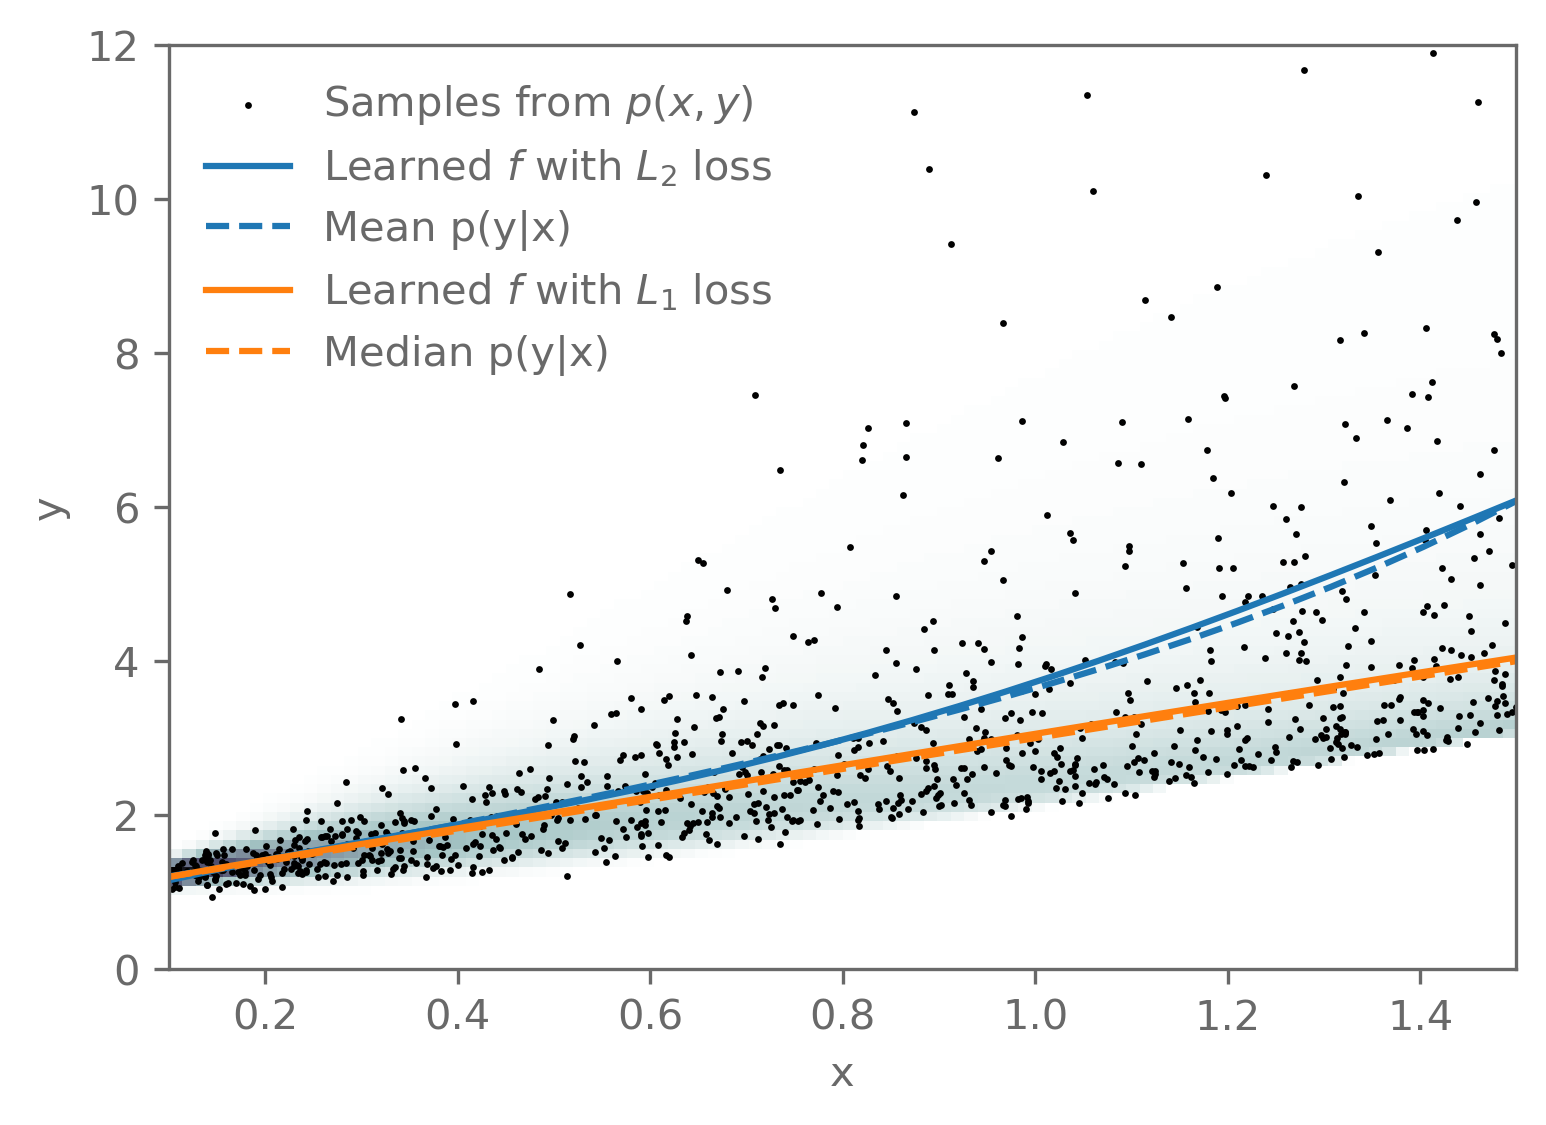

In [146]:
x_test = jnp.linspace(0.1, 1.5, 30)
mean_y_test = distr(x_test).mean()
median_y_test = distr(x_test).median()

L1_predictions_test = L1_trained_model(x_test[:, None])
L2_predictions_test = L2_trained_model(x_test[:, None])

fig, ax = plt.subplots(1, 1)
ax.scatter(x, y, s=0.4, color="black", label="Samples from $p(x, y)$")

ax.plot(x_test, L2_predictions_test, ls="-", c="C0", label="Learned $f$ with $L_2$ loss")
ax.plot(x_test, mean_y_test, c="C0", ls="--", label="Mean p(y|x)")
ax.plot(x_test, L1_predictions_test, ls="-", c="C1", label="Learned $f$ with $L_1$ loss")
ax.plot(x_test, median_y_test, c="C1", ls="--", label="Median p(y|x)")


ax.legend(frameon=False)

x_grid = np.linspace(0.1, 1.5, 100)
y_grid = np.linspace(0, 12, 100)
pdf_grid = distr(x_grid).pdf(y_grid[:,None])
ax.imshow(
    pdf_grid,
    origin="lower",
    extent=(min(x_grid), max(x_grid), min(y_grid), max(y_grid)),
    cmap="bone_r"
)
ax.set_aspect(0.08)

ax.set_xlabel("x")
ax.set_ylabel("y");

How does this approach of minimising a loss function compare to what we have been doing in the Bayesian context? For example, finding the maximum of the posterior?

The mode $\theta^*$ of the posterior $p(\theta|x, y)$ is
$$
    \theta^* = \underset{\theta}{\mathrm{argmax}}\ p(\theta|x, y) \,.
$$


Writing this in terms of the logarithm of the likelihood and prior
$$
    \theta^* = \underset{\theta}{\mathrm{argmax}}\left[ \log p(y | x, \theta) + \log p(\theta | x) \right] \,.
$$

Or equivalently
$$
    \theta^* = \underset{\theta}{\mathrm{argmin}}\left[ -\log p(y | x, \theta) -\log p(\theta | x) \right] \,.
$$



This can be seen as minimising a loss function (the negative log-likelihood) with a regularisation term (the negative log-prior).

In case of a Gaussian likelihood, this corresponds to a (weighted) $L_2$ loss.

We have seen that using the $L_2$ loss yields a function $f_\theta(x)$ that approximates the mean of the conditional data distribution $p(y | x)$.

What loss function do we need to use to get an approximation of the mode? Or better yet, the full distribution?



Instead of having our neural network predict a point estimate of $y$ given $x$, we have the network predict a distribution $q(y|x)$ of $y$ given $x$. 

We achieve this by having the network $f_\theta(x)$ predict parameters $\phi$ based on the input $x$, which parametrise the distribution $q_\phi(y|x)$.


We then optimise the network using the KL loss from the discussion on conditional density estimation:
$$
    L_\mathrm{KL}(x, y) = -\frac{1}{n}\sum_i \log q_{\phi = f(x)}(y_i)
$$

Here we use a Gaussian mixture model again for $q_\phi$. There are more flexible options, such as normalising flows as well but these are a bit more involved to implement.

In [147]:
def NLL_loss_fn(params, model, x, y):
    q = model.apply(params, x)
    # Compute the negative log likelihood of the outputs
    nll = - q.log_prob(y[:, 0])
    return jnp.mean(nll)

In [148]:
# We need to adapt our model a bit to make the output a distribution.
class MDN(nn.Module):
    n_hidden: int = 128
    n_components: int = 8
    n_output: int = 1

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=self.n_hidden)(x)
        x = nn.swish(x)
        x = nn.Dense(features=self.n_hidden)(x)
        x = nn.swish(x)
        x = nn.tanh(nn.Dense(features=self.n_components)(x))

        # Predict the weights, means, and standard deviations of the 
        # Gaussian mixture model
        categorical_logits = nn.Dense(self.n_components)(x)
        loc = nn.Dense(self.n_components)(x)
        scale = nn.softplus(nn.Dense(self.n_components)(x))

        # Build the distribution based on these parameters
        dist = tfd.Independent(
            tfd.MixtureSameFamily(
                mixture_distribution=tfd.Categorical(logits=categorical_logits),
                components_distribution=tfd.Normal(loc=loc, scale=scale)
            )
        )
        return dist

In [149]:
model = MDN(n_components=16)

params, loss = train(model, NLL_loss_fn, n_iter=1000, seed=jax.random.PRNGKey(42))
NLL_trained_model = model.bind(params)

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:08<00:00, 247.38it/s, loss=0.9764868] 


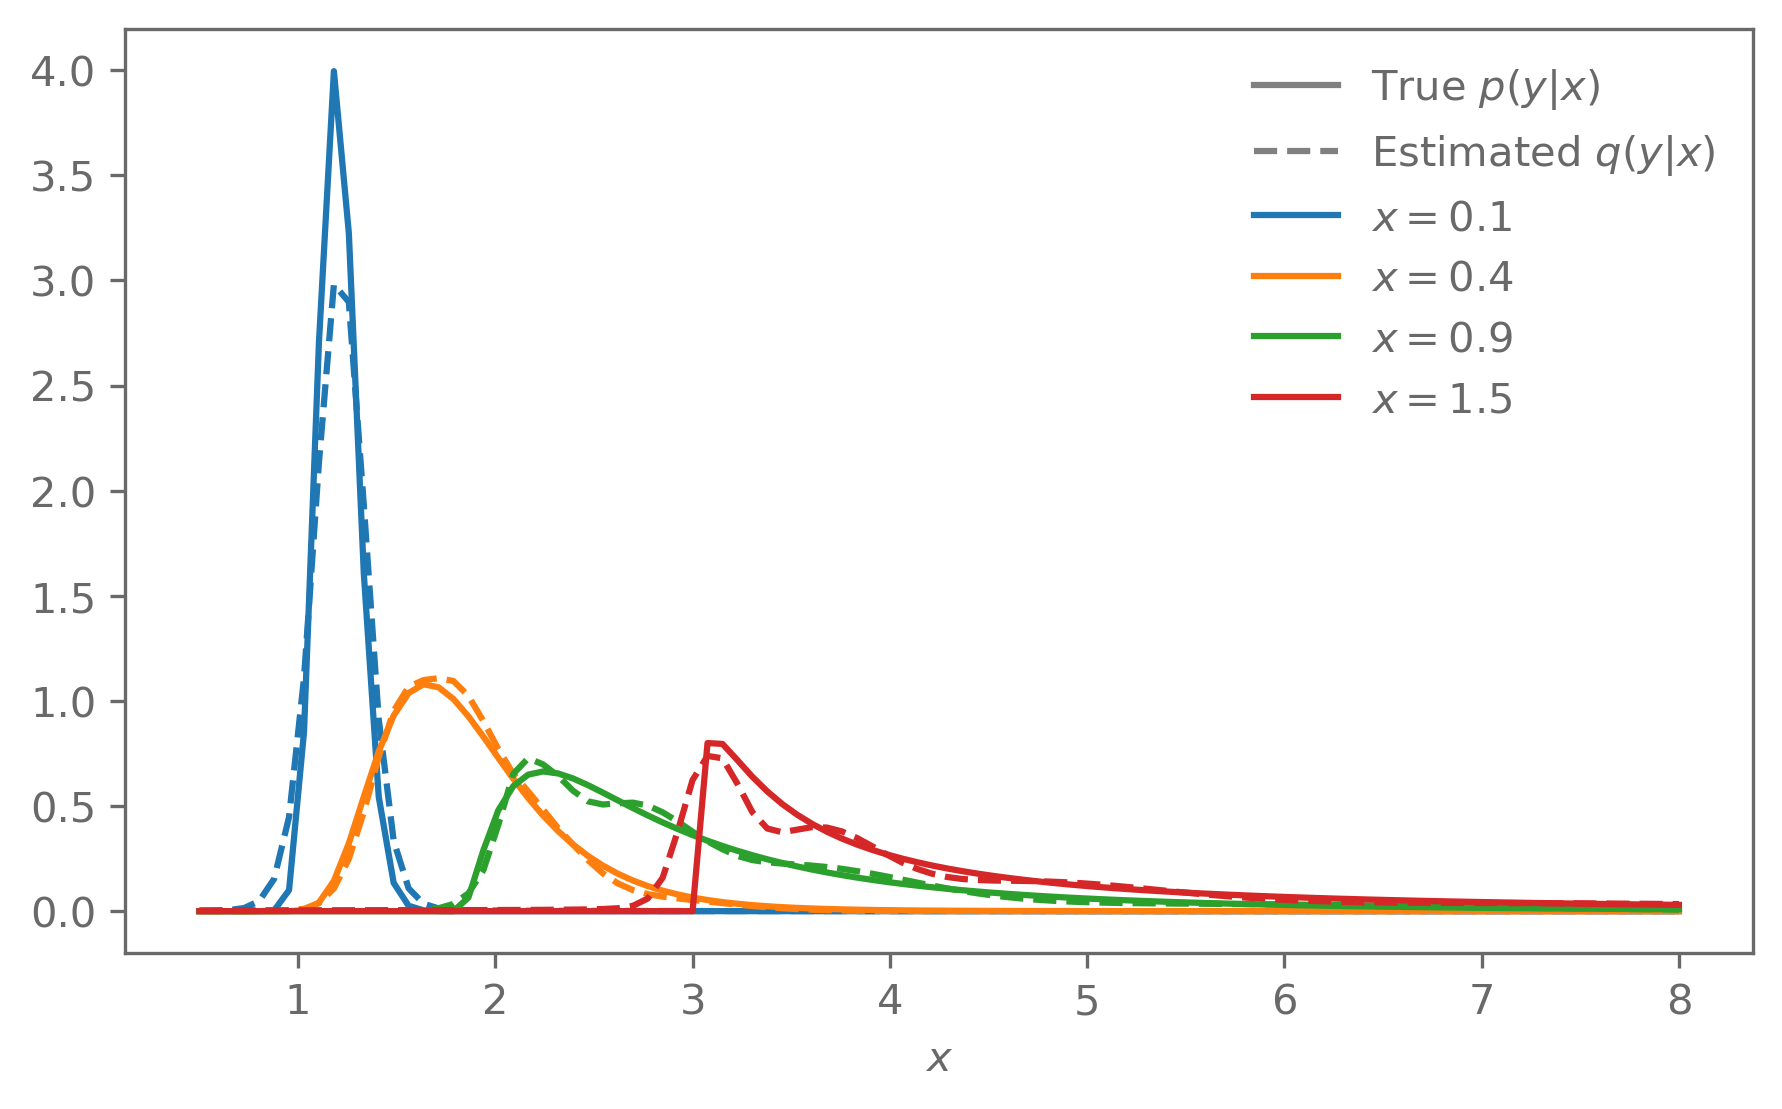

In [150]:
y_grid = np.linspace(0.5, 8, 100)

plt.plot([], [], c="grey", label="True $p(y|x)$")
plt.plot([], [], c="grey", ls="--", label="Estimated $q(y|x)$")

for i, x_test in enumerate([0.1, 0.4, 0.9, 1.5]):
    q = NLL_trained_model([x_test])
    plt.plot(y_grid, distr(x_test).pdf(y_grid), c=f"C{i}", label="$x =$" + f"{x_test}")
    plt.plot(y_grid, np.exp(q.log_prob(y_grid)), c=f"C{i}", ls="--")

plt.legend()
plt.xlabel("$x$");

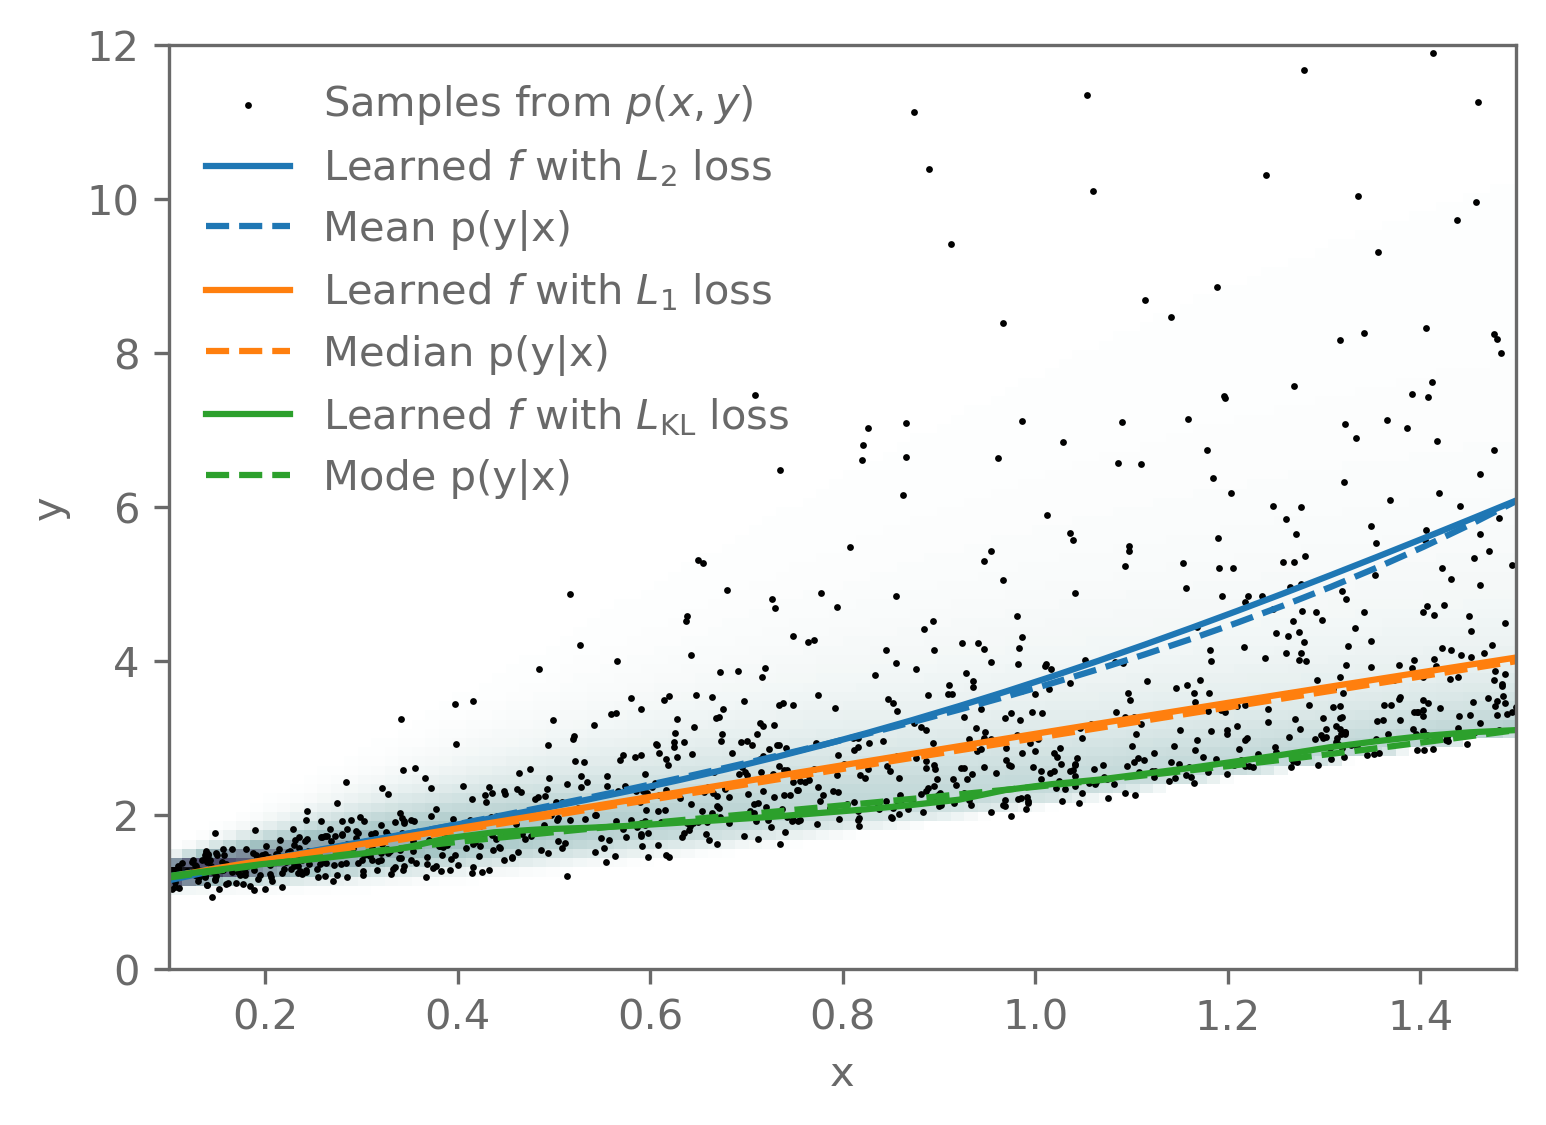

In [151]:
def mode_grid(x):
    q = NLL_trained_model(x[:, None])
    y_grid = np.linspace(0.2, 5, 500)
    log_prob = q.log_prob(y_grid[:, None])
    
    return y_grid[jnp.argmax(log_prob, axis=0)]

x_test = jnp.linspace(0.1, 1.5, 30)
mean_y_test = distr(x_test).mean()
median_y_test = distr(x_test).median()
mode_y_test = distr(x_test).mode()

L1_predictions_test = L1_trained_model(x_test[:, None])
L2_predictions_test = L2_trained_model(x_test[:, None])
NLL_predictions_test = mode_grid(x_test)

fig, ax = plt.subplots(1, 1)
ax.scatter(x, y, s=0.4, color="black", label="Samples from $p(x, y)$")

ax.plot(x_test, L2_predictions_test, ls="-", c="C0", label="Learned $f$ with $L_2$ loss")
ax.plot(x_test, mean_y_test, c="C0", ls="--", label="Mean p(y|x)")
ax.plot(x_test, L1_predictions_test, ls="-", c="C1", label="Learned $f$ with $L_1$ loss")
ax.plot(x_test, median_y_test, c="C1", ls="--", label="Median p(y|x)")
ax.plot(x_test, NLL_predictions_test, ls="-", c="C2", label="Learned $f$ with $L_\mathrm{KL}$ loss")
ax.plot(x_test, mode_y_test, c="C2", ls="--", label="Mode p(y|x)")

ax.legend(frameon=False)

x_grid = np.linspace(0.1, 1.5, 100)
y_grid = np.linspace(0, 12, 100)
pdf_grid = distr(x_grid).pdf(y_grid[:,None])
ax.imshow(
    pdf_grid,
    origin="lower",
    extent=(min(x_grid), max(x_grid), min(y_grid), max(y_grid)),
    cmap="bone_r"
)
ax.set_aspect(0.08)

ax.set_xlabel("x")
ax.set_ylabel("y");

## Exercise

Show that the function that minimises the $L_1$ loss is the median.

Try the neural network predictor on the toy data sets we looked at so far. Does it work with few samples? How many data points do you need for it to work reliably? You can reuse the function from the ABC exercise to create new data points.


### Project idea

In this [Google colab notebook](https://colab.research.google.com/drive/1A9wG9UVIRbWjxtM5XzDO3Sqc-aY5TzLJ) is a demonstration on how to use these methods to estimate the mass of galaxy clusters from the number of galaxies and their velocity dispersion.
A possible project would be to work through this yourself as well as the associated paper that goes into more of the details.